In [1]:
import pandas as pd
import numpy as np
from viz import show_field
from tools import make_move, generate_field

In [2]:
df = pd.read_csv('resources/train.csv', index_col='id')

In [3]:
sample = df[df.delta == 1].sample(random_state=42)
X, Y = sample.values[:, 1:401], sample.values[:, 401:]

In [4]:
sample

,delta,start.1,start.2,start.3,start.4,start.5,start.6,start.7,start.8,start.9,...,stop.391,stop.392,stop.393,stop.394,stop.395,stop.396,stop.397,stop.398,stop.399,stop.400
id,,,,,,,,,,,,,,,,,,,,,
28539,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


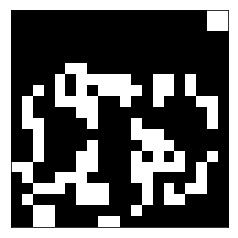

In [5]:
show_field(X)

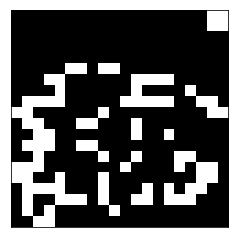

In [6]:
show_field(Y)

In [7]:
Y = Y.reshape((20, 20))

In [8]:
def fitness(start_field, end_field, delta=1):
    candidate = make_move(start_field, moves=delta)
    return (candidate == end_field).sum() / 400

In [215]:
# sanity checks
assert fitness(X.reshape((20, 20)), Y, 1) == 1
assert fitness(Y, Y, 0) == 1

In [52]:
def gen_population(size, random_state=-1):
    if random_state != -1:
        np.random.seed(random_state)
    return [generate_field(5) for _ in range(size)]

In [53]:
population = gen_population(10, 42)

In [54]:
[fitness(_, Y) for _ in population]

[0.7125, 0.71, 0.6075, 0.705, 0.7125, 0.6575, 0.665, 0.625, 0.645, 0.625]

In [57]:
def crossover(mom, dad):
    """
    Take two parents, return two children
    """
    select_mask = np.random.randint(0, 2, size=(20, 20), dtype='bool')
    child1, child2 = np.copy(mom), np.copy(dad)
    child1[select_mask] = dad[select_mask]
    child2[select_mask] = mom[select_mask]
    return child1, child2

In [150]:
def mutate(field):
    """
    Inplace mutation of the provided field
    """
    a = np.random.randint(0, 100, size=(20, 20), dtype='uint8')
    a[a < 90] = 0
    a[a >= 90] = 1
    a = a.astype('bool')
    field[a] += 1
    field[a] %= 2
    return field

In [475]:
np.random.binomial(1, 0.5, (20, 20)).shape

(20, 20)

In [360]:
def evolve(population, target, delta, retain_best=0.75, retain_random=0.05, mutate_chance=0.05, verbose=False):
    """
    Evolve population

    """
    scores = np.array([fitness(_, target, delta) for _ in population])
    retain_len = int(len(scores) * retain_best)
    sorted_indices = np.argsort(scores)[::-1]
    population = [population[idx] for idx in sorted_indices]
    best_scores = scores[sorted_indices][:retain_len]
    if verbose:
        print("best scores:", best_scores)
    parents = population[:retain_len]
    leftovers = population[retain_len:]
    
    cnt_degenerate = 0
    for gene in leftovers:
        if np.random.rand() < retain_random:
            cnt_degenerate += 1
            parents.append(gene)
    if verbose:
        print(f"# of degenerates left: {cnt_degenerate}")
    
    cnt_mutations = 0
    for gene in parents:  # mutate everyone expect for the best candidate
        if np.random.rand() < mutate_chance:
            mutate(gene)
            cnt_mutations += 1
    if verbose:
        print(f"# of mutations: {cnt_mutations}")
    
    places_left = len(population) - len(parents)
    children = []
    while len(children) < places_left:
        mom_idx, dad_idx = np.random.randint(0, len(parents) - 1, 2)
        if mom_idx != dad_idx:
            child1, child2 = crossover(parents[mom_idx], parents[dad_idx])
            children.append(child1)
            if len(children) < places_left:
                children.append(child2)
    if verbose:
        print(f"# of children: {len(children)}")
    parents.extend(children)
    return parents, best_scores

In [341]:
population = gen_population(200, 42)

In [342]:
for epoch in range(1000):
    population, scores = evolve(population, Y)
    print(f"Epoch {epoch}: {scores[0]}")

Epoch 0: 0.7325
Epoch 1: 0.7325
Epoch 2: 0.7325
Epoch 3: 0.7325
Epoch 4: 0.7375
Epoch 5: 0.7375
Epoch 6: 0.7375
Epoch 7: 0.7375
Epoch 8: 0.7375
Epoch 9: 0.75
Epoch 10: 0.7475
Epoch 11: 0.7575
Epoch 12: 0.7625
Epoch 13: 0.7625
Epoch 14: 0.76
Epoch 15: 0.76
Epoch 16: 0.77
Epoch 17: 0.77
Epoch 18: 0.77
Epoch 19: 0.775
Epoch 20: 0.775
Epoch 21: 0.775
Epoch 22: 0.775
Epoch 23: 0.775
Epoch 24: 0.775
Epoch 25: 0.785
Epoch 26: 0.79
Epoch 27: 0.795
Epoch 28: 0.795
Epoch 29: 0.795
Epoch 30: 0.795
Epoch 31: 0.795
Epoch 32: 0.795
Epoch 33: 0.8
Epoch 34: 0.8
Epoch 35: 0.7975
Epoch 36: 0.7975
Epoch 37: 0.7975
Epoch 38: 0.7925
Epoch 39: 0.8
Epoch 40: 0.8
Epoch 41: 0.8
Epoch 42: 0.8
Epoch 43: 0.8
Epoch 44: 0.8
Epoch 45: 0.8
Epoch 46: 0.8025
Epoch 47: 0.8025
Epoch 48: 0.8025
Epoch 49: 0.81
Epoch 50: 0.81
Epoch 51: 0.81
Epoch 52: 0.81
Epoch 53: 0.8125
Epoch 54: 0.8125
Epoch 55: 0.8125
Epoch 56: 0.8125
Epoch 57: 0.8125
Epoch 58: 0.8125
Epoch 59: 0.8125
Epoch 60: 0.815
Epoch 61: 0.815
Epoch 62: 0.815
Epoc

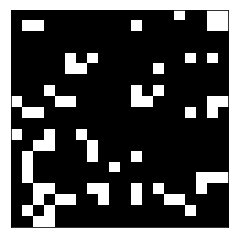

In [345]:
show_field(population[0])

In [352]:
sample = df[df.delta == 3].sample(1)

In [353]:
X = sample.values[:, 1:401].reshape((20, 20))
Y = sample.values[:, 401:].reshape((20, 20))

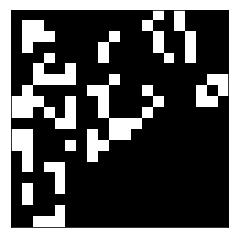

In [354]:
show_field(X)

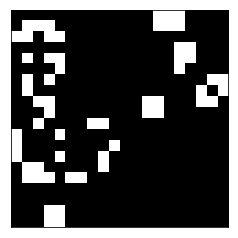

In [355]:
show_field(Y)

In [ ]:
population = gen_population(200, 42)

In [379]:
for epoch in range(300):
    population, scores = evolve(population, Y, delta=3, mutate_chance=0.09)
    print(f"Epoch {epoch}: {scores[0]}")

Epoch 0: 0.895
Epoch 1: 0.895
Epoch 2: 0.895
Epoch 3: 0.895
Epoch 4: 0.895
Epoch 5: 0.895
Epoch 6: 0.895
Epoch 7: 0.895
Epoch 8: 0.895
Epoch 9: 0.895
Epoch 10: 0.8925
Epoch 11: 0.8925
Epoch 12: 0.8925
Epoch 13: 0.8925
Epoch 14: 0.8975
Epoch 15: 0.8975
Epoch 16: 0.895
Epoch 17: 0.895
Epoch 18: 0.895
Epoch 19: 0.895
Epoch 20: 0.895
Epoch 21: 0.895
Epoch 22: 0.895
Epoch 23: 0.895
Epoch 24: 0.895
Epoch 25: 0.895
Epoch 26: 0.895
Epoch 27: 0.895
Epoch 28: 0.895
Epoch 29: 0.895
Epoch 30: 0.895
Epoch 31: 0.895
Epoch 32: 0.895
Epoch 33: 0.8925
Epoch 34: 0.8925
Epoch 35: 0.8925
Epoch 36: 0.8925
Epoch 37: 0.8925
Epoch 38: 0.8925
Epoch 39: 0.8925
Epoch 40: 0.8925
Epoch 41: 0.8925
Epoch 42: 0.8925
Epoch 43: 0.8925
Epoch 44: 0.8925
Epoch 45: 0.8925
Epoch 46: 0.8925
Epoch 47: 0.8925
Epoch 48: 0.8925
Epoch 49: 0.8925
Epoch 50: 0.8925
Epoch 51: 0.8925
Epoch 52: 0.8925
Epoch 53: 0.8925
Epoch 54: 0.8925
Epoch 55: 0.8925
Epoch 56: 0.8925
Epoch 57: 0.8925
Epoch 58: 0.8925
Epoch 59: 0.8925
Epoch 60: 0.8925


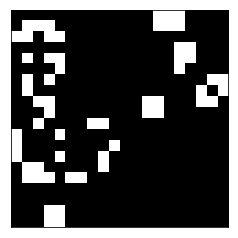

In [380]:
show_field(Y)

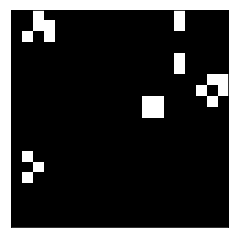

In [381]:
show_field(make_move(population[0], 3))

In [382]:
from sklearn.metrics import mean_absolute_error

In [383]:
fitness(population[0], Y, 3)

0.8925

In [384]:
mean_absolute_error(Y, make_move(population[0], 3))

0.1075

In [405]:
def gen_population_covering(size):
    """ Generate population using binomial distribution with uniform coverage of success probability """
    alive_probabilities = np.linspace(0.01, 0.99, size)
    return [make_move(np.random.binomial(1, prob, 400).reshape((20, 20)), 5) for prob in alive_probabilities]

In [406]:
covering_population = gen_population_covering(200)

In [409]:
for epoch in range(300):
    covering_population, scores = evolve(covering_population, Y, delta=3, mutate_chance=0.09)
    print(f"Epoch {epoch}: {scores[0]}")

Epoch 0: 0.8925
Epoch 1: 0.8925
Epoch 2: 0.8925
Epoch 3: 0.8925
Epoch 4: 0.8925
Epoch 5: 0.8925
Epoch 6: 0.8925
Epoch 7: 0.8925
Epoch 8: 0.8925
Epoch 9: 0.8925
Epoch 10: 0.8925
Epoch 11: 0.8925
Epoch 12: 0.8925
Epoch 13: 0.8925
Epoch 14: 0.8925
Epoch 15: 0.8925
Epoch 16: 0.8925
Epoch 17: 0.8925
Epoch 18: 0.8925
Epoch 19: 0.8925
Epoch 20: 0.8925
Epoch 21: 0.8925
Epoch 22: 0.8925
Epoch 23: 0.8925
Epoch 24: 0.8925
Epoch 25: 0.8925
Epoch 26: 0.8925
Epoch 27: 0.8925
Epoch 28: 0.8925
Epoch 29: 0.8925
Epoch 30: 0.8925
Epoch 31: 0.8925
Epoch 32: 0.8925
Epoch 33: 0.8925
Epoch 34: 0.8925
Epoch 35: 0.8925
Epoch 36: 0.8925
Epoch 37: 0.8925
Epoch 38: 0.8925
Epoch 39: 0.8925
Epoch 40: 0.8925
Epoch 41: 0.8925
Epoch 42: 0.8925
Epoch 43: 0.8925
Epoch 44: 0.8925
Epoch 45: 0.8925
Epoch 46: 0.8925
Epoch 47: 0.8925
Epoch 48: 0.8925
Epoch 49: 0.8925
Epoch 50: 0.8925
Epoch 51: 0.8925
Epoch 52: 0.8925
Epoch 53: 0.8925
Epoch 54: 0.8925
Epoch 55: 0.8925
Epoch 56: 0.8925
Epoch 57: 0.8925
Epoch 58: 0.8925
Epoch 5

In [410]:
s = covering_population[0]

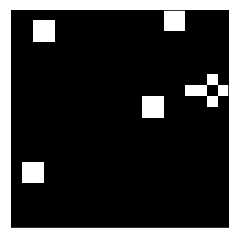

In [427]:
show_field(make_move(s, 3))

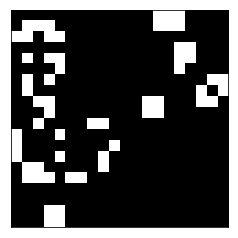

In [413]:
show_field(Y)

In [453]:
sample = df[df.delta==5].sample()
X, Y = sample.values[:, 1:401].reshape((20, 20)), sample.values[:, 401:].reshape((20, 20))

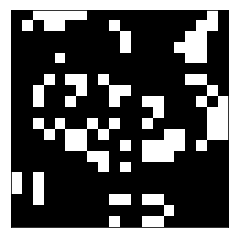

In [454]:
show_field(X)

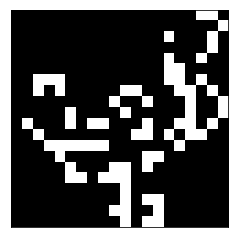

In [455]:
show_field(Y)

In [456]:
fitness(X, Y, 5)

1.0

In [457]:
fitness(Y, Y, 0)

1.0

In [477]:
covering_population = gen_population_covering(200)

In [478]:
for epoch in range(500):
    covering_population, scores = evolve(covering_population, Y, delta=5, mutate_chance=0.09)
    print(f"Epoch {epoch}: {scores[0]}")

Epoch 0: 0.8175


KeyboardInterrupt: 

In [460]:
s = covering_population[0]

In [461]:
mean_absolute_error(make_move(s, 5), Y)

0.14250000000000002

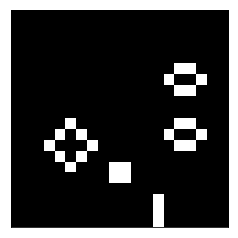

In [472]:
show_field(make_move(s, 5))

In [474]:
fitness(np.zeros((20, 20)), Y)

0.815

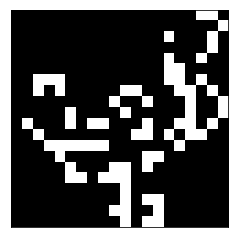

In [473]:
show_field(Y)

In [482]:
scores

array([0.8175, 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 ,
       0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 ,
       0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 ,
       0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 ,
       0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 ,
       0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.815 ,
       0.815 , 0.815 , 0.815 , 0.815 , 0.815 , 0.8125, 0.81  , 0.81  ,
       0.8075, 0.805 , 0.805 , 0.805 , 0.805 , 0.805 , 0.805 , 0.805 ,
       0.805 , 0.805 , 0.805 , 0.805 , 0.805 , 0.805 , 0.805 , 0.8025,
       0.8   , 0.8   , 0.8   , 0.8   , 0.795 , 0.795 , 0.795 , 0.795 ,
       0.795 , 0.795 , 0.795 , 0.795 , 0.7925, 0.7925, 0.79  , 0.79  ,
       0.79  , 0.79  , 0.79  , 0.7875, 0.7875, 0.785 , 0.7825, 0.7825,
       0.78  , 0.78  , 0.78  , 0.7775, 0.7775, 0.775 , 0.775 , 0.775 ,
       0.775 , 0.7725, 0.77  , 0.7675, 0.765 , 0.765 , 0.7625, 0.76  ,
      

In [485]:
fitness([0], Y, 5)

0.8175

In [486]:
from GeneticSolver import GeneticSolver

In [489]:
gn = GeneticSolver(verbose=True)

In [490]:
gn.solve(Y, 5)

best scores: [0.7975 0.78   0.7775 0.7775 0.7725 0.7675 0.7625 0.7625 0.76   0.76
 0.76   0.76   0.7525 0.7525 0.75   0.75   0.7475 0.7475 0.7475 0.7475
 0.745  0.745  0.7425 0.7425 0.74   0.74   0.74   0.74   0.7375 0.7375
 0.7375 0.7375 0.7375 0.735  0.735  0.7325 0.7325 0.7325 0.7325 0.7325
 0.7325 0.7325 0.7325 0.7325 0.73   0.73   0.73   0.73   0.73   0.73
 0.73   0.73   0.7275 0.7275 0.7275 0.7275 0.725  0.725  0.725  0.725
 0.7225 0.7225 0.7225 0.7225 0.72   0.72   0.72   0.72   0.7175 0.7175
 0.7175 0.7175 0.715  0.715  0.715  0.715  0.715  0.7125 0.7125 0.7125
 0.7125 0.7125 0.71   0.71   0.71   0.71   0.71   0.71   0.71   0.71
 0.71   0.71   0.71   0.7075 0.7075 0.7075 0.7075 0.7075 0.7075 0.7075
 0.705  0.705  0.705  0.705  0.705  0.705  0.705  0.705  0.705  0.7025
 0.7025 0.7025 0.7025 0.7025 0.7025 0.7025 0.7025 0.7025 0.7    0.7
 0.7    0.7    0.7    0.7    0.7    0.7    0.6975 0.6975 0.6975 0.6975
 0.6975 0.6975 0.695  0.6925 0.6925 0.6925 0.6925 0.6925 0.69   0.69
 0.69

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0,